In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [3]:
#from keras.applications.efficientnet import EfficientNetB7

### Importing flower set from tensorflow dataset

In [4]:
splits=['train[:80%]','train[80%:]']
(f_training_set, f_validation_set), f_dataset_info = tfds.load(
'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=splits
)

In [5]:
num_training_examples =len(f_training_set)
num_classes = f_dataset_info.features['label'].num_classes
num_validation_examples = len(f_validation_set)

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2936
Total Number of Validation Images: 734 



In [6]:
class_names = np.array(f_dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [7]:
for i, example in enumerate(f_training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [8]:
IMAGE_RES = 224
#IMAGE_SIZE = [224, 224]
def format_image(image, label):
    image =tf.image.resize(image,(IMAGE_RES,IMAGE_RES ))/255.0
    return image, label

BATCH_SIZE = 32


f_train_batches = f_training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

f_validation_batches = f_validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

## importing Feature extractor without last layer

In [10]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable=False

In [11]:
model=tf.keras.Sequential([feature_extractor,layers.Dense(len(class_names))])

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
EPOCHS=6
history = model.fit(f_train_batches,epochs=EPOCHS,
                    validation_data=f_validation_batches)

Epoch 1/6
92/92 [==============================] - 92s 936ms/step - loss: 0.7448 - accuracy: 0.7241 - val_loss: 0.4443 - val_accuracy: 0.8420
Epoch 2/6
92/92 [==============================] - 84s 917ms/step - loss: 0.3810 - accuracy: 0.8716 - val_loss: 0.3455 - val_accuracy: 0.8733
Epoch 3/6
92/92 [==============================] - 84s 916ms/step - loss: 0.2930 - accuracy: 0.9067 - val_loss: 0.2957 - val_accuracy: 0.8869
Epoch 4/6
92/92 [==============================] - 84s 913ms/step - loss: 0.2437 - accuracy: 0.9237 - val_loss: 0.2759 - val_accuracy: 0.8992
Epoch 5/6
92/92 [==============================] - 84s 916ms/step - loss: 0.2104 - accuracy: 0.9373 - val_loss: 0.2583 - val_accuracy: 0.9033
Epoch 6/6
92/92 [==============================] - 84s 916ms/step - loss: 0.1871 - accuracy: 0.9496 - val_loss: 0.2569 - val_accuracy: 0.9005


#### displaying accuracy and loss chart

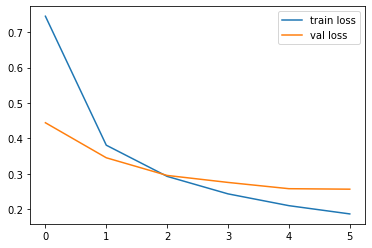

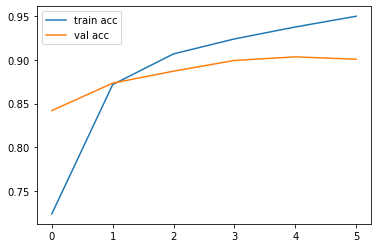

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#### Prediction for one batch

In [17]:
image_batch, label_batch = next(iter(f_train_batches))
image_batch=image_batch.numpy()
label_batch=label_batch.numpy()


predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names =  [class_names[j] for j in predicted_ids]  # class_names[predicted_ids]


In [18]:
print('Original labels',label_batch)
print('predicted',predicted_ids)

Original labels [3 0 4 0 3 4 2 3 4 0 3 0 0 0 1 2 3 3 4 4 1 3 3 0 1 4 1 1 4 1 0 2]
predicted [3 0 4 0 3 4 2 3 4 0 3 0 0 0 1 2 3 3 4 4 1 4 3 0 1 4 1 1 4 1 0 2]


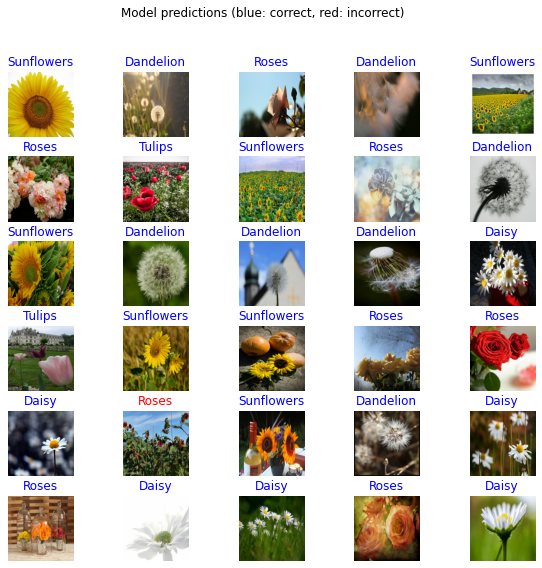

In [19]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

### Import local data for transfer learing

In [ ]:
#next(iter(validation_batch))[0][0][0].numpy().max()

In [53]:
IMAGE_SIZE = [224, 224]

train_path = os.path.join(os.getcwd(),'data','transfer-lr-ds','train')
valid_path = os.path.join(os.getcwd(),'data','transfer-lr-ds','test')

class_names =[os.path.basename(j)  for j in glob(os.path.join(train_path,'*')) ]
print(class_names)

['Lucky', 'Madhu', 'Madhuri', 'Rajesh']


In [54]:
training_batch=tf.keras.utils.image_dataset_from_directory(train_path,  batch_size=10,  
                                            
                                            seed=123,
                                            image_size=IMAGE_SIZE)

validation_batch=tf.keras.utils.image_dataset_from_directory(valid_path,  batch_size=10,  
                                            seed=123,
                                            image_size=IMAGE_SIZE)

Found 84 files belonging to 4 classes.
Found 7 files belonging to 4 classes.


In [55]:
def format_image(image, label):
    image =image/255.0
    return image, label

In [56]:
training_batch.map(format_image)
validation_batch.map(format_image)

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [57]:
EPOCHS = 6
history=model.fit(training_batch,epochs=6,validation_data=validation_batch)

Epoch 1/6
9/9 [==============================] - 5s 303ms/step - loss: 0.6418 - accuracy: 0.7857 - val_loss: 2.6633 - val_accuracy: 0.2857
Epoch 2/6
9/9 [==============================] - 5s 314ms/step - loss: 0.5439 - accuracy: 0.8214 - val_loss: 1.9248 - val_accuracy: 0.2857
Epoch 3/6
9/9 [==============================] - 5s 302ms/step - loss: 0.5304 - accuracy: 0.8452 - val_loss: 2.4458 - val_accuracy: 0.2857
Epoch 4/6
9/9 [==============================] - 5s 313ms/step - loss: 0.4953 - accuracy: 0.8214 - val_loss: 2.2028 - val_accuracy: 0.2857
Epoch 5/6
9/9 [==============================] - 5s 308ms/step - loss: 0.5135 - accuracy: 0.8333 - val_loss: 2.1142 - val_accuracy: 0.2857
Epoch 6/6
9/9 [==============================] - 5s 309ms/step - loss: 0.4631 - accuracy: 0.8810 - val_loss: 2.4566 - val_accuracy: 0.2857


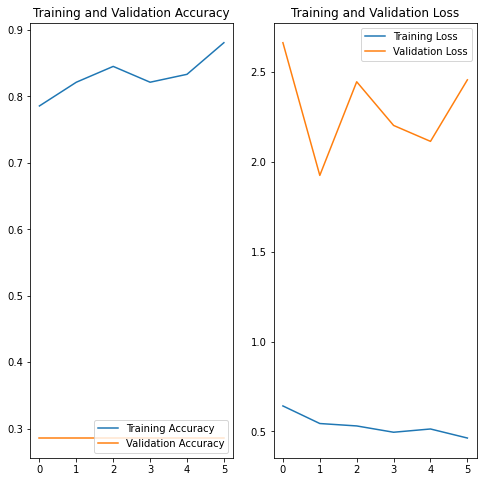

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 

#### Predictions

In [59]:
image_batch, label_batch = next(iter(training_batch))
image_batch=image_batch.numpy()
label_batch=label_batch.numpy()


predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names =  [class_names[j] for j in predicted_ids]  # class_names[predicted_ids]


In [143]:
print('Original labels',label_batch)
print('predicted',predicted_ids)

Original labels [3 0 2 2 2 2 0 3 1 2]
predicted [3 0 2 2 2 2 0 1 1 2]
